In [1]:
from datasets import load_dataset

dataset = load_dataset('squad')['train'].train_test_split(test_size=0.2)

In [2]:
import torch
import intel_extension_for_pytorch as ipex

/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dataset["train"][0]

{'id': '56fa00e2f34c681400b0bf4b',
 'title': 'Somalis',
 'context': 'According to most scholars, the ancient Land of Punt and its inhabitants formed part of the ethnogenesis of the Somali people. The ancient Puntites were a nation of people that had close relations with Pharaonic Egypt during the times of Pharaoh Sahure and Queen Hatshepsut. The pyramidal structures, temples and ancient houses of dressed stone littered around Somalia are said to date from this period.',
 'question': 'What ancient land was connected to the modern Somali people?',
 'answers': {'text': ['Land of Punt'], 'answer_start': [40]}}

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")

In [23]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [24]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/70079 [00:00<?, ? examples/s]

Map:   0%|          | 0/17520 [00:00<?, ? examples/s]

In [25]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [26]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

In [27]:
import evaluate
accuracy = evaluate.load("accuracy")

In [ ]:
training_args = TrainingArguments(
    output_dir="qa_finetune",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    use_ipex=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.413200,0.573162
2,0.148900,0.776654


/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


In [33]:
import numpy as np
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import collections

In [36]:
model_checkpoint = "qa_finetune/checkpoint-4380"
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [37]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")

model.eval()

model = model.to("xpu")
inputs = inputs.to("xpu")

import time
num_times = 100
warmup_rounds = 20

latency_list = []
for i in range(num_times):
    time_start = time.time()
    outputs = model(**inputs)
    if i >= warmup_rounds:
        latency_list.append(time.time() - time_start)

fp32_inference_time = np.mean(latency_list)
print("Inference time for FP32 took %.3f seconds" %(fp32_inference_time))

Inference time for FP32 took 0.005 seconds


In [38]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")

model.eval()

model = model.to("xpu")
inputs = inputs.to("xpu")

import time
num_times = 100
warmup_rounds = 20

model = ipex.optimize(model, dtype=torch.bfloat16)
latency_list = []
with torch.no_grad():
    ########################### code changes ########################
    with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
    ########################### code changes ########################
        for i in range(num_times):
            time_start = time.time()
            outputs = model(**inputs)
            if i >= warmup_rounds:
                latency_list.append(time.time() - time_start)

bf16_inference_time = np.mean(latency_list)
print("Inference time for BF16 took %.3f seconds" %(bf16_inference_time))

/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


Inference time for BF16 took 0.004 seconds


In [39]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
vocab_size = model.config.vocab_size


model.eval()

model = model.to("xpu")
model = ipex.optimize(model, dtype=torch.float16)
with torch.no_grad():
    seq_length = 256
    d= {
        'input_ids': torch.randint(vocab_size, size=[1, seq_length]).to("xpu"),
        'attention_mask': torch.ones(1, seq_length, dtype=torch.int64).to("xpu")   
    }
    
    with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
    ############################# code changes #####################
        model = torch.jit.trace(model, (d['input_ids'],d['attention_mask'],), strict=False) #, check_trace=False
        model = torch.jit.freeze(model)
        traced_model_path = "traced_model.pt"
        torch.jit.save(model, traced_model_path)

    with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
        inputs = tokenizer(question, context, return_tensors="pt")
        inputs = {
            'input_ids': inputs['input_ids'].to("xpu"),
            'attention_mask': inputs['attention_mask'].to("xpu")
        }
        latency_list = []
        for i in range(num_times):
            time_start = time.time()
            outputs = model(**inputs)
            if i >= warmup_rounds:
                latency_list.append(time.time() - time_start)

torchscript_inference_time = np.mean(latency_list)
print("Inference time for Torchscript took %.3f seconds" %(torchscript_inference_time))

/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:246: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


Inference time for Torchscript took 0.003 seconds


In [40]:
"""
Prints out results and displays figures summarizing output.
"""

def summarize_results(modelName="", results=None):
    """
    Input parameters
        modelName: a str representing the name of the model
        results: a dict with the run case and its corresponding time in seconds
    Return value
        None
    """

    # Inference time results
    print("\nSummary for %s" %(modelName))
    for key in results.keys():
        print("%s inference time: %.3f seconds" %(key, results[key]))

    # Create bar chart with inference time results
    plt.figure()
    plt.title("%s Inference Time" %(modelName))
    plt.xlabel("Run Case")
    plt.ylabel("Inference Time (seconds)")
    plt.bar(results.keys(), results.values())

    # Calculate speedup when using AMX
    print("\n")
    bf16_speedup = results["FP32"] / results["BF16"]
    print("BF16 with AMX is %.2fX faster than FP32" %bf16_speedup)
    torchscript_speedup = results["FP32"] / results["TorchScript"]
    print("Torchscript is %.2fX faster than FP32" %torchscript_speedup)
    print("\n\n")

    # Create bar chart with speedup results
    plt.figure()
    plt.title("%s AMX BF16 Speedup over FP32" %modelName)
    plt.xlabel("Run Case")
    plt.ylabel("Speedup")
    plt.bar(results.keys(), 
        [1, bf16_speedup, torchscript_speedup]
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-03-24 01:04:44,278 - matplotlib.font_manager - INFO - generated new fontManager



Summary for QA
FP32 inference time: 0.005 seconds
BF16 inference time: 0.004 seconds
TorchScript inference time: 0.003 seconds


BF16 with AMX is 1.23X faster than FP32
Torchscript is 1.87X faster than FP32





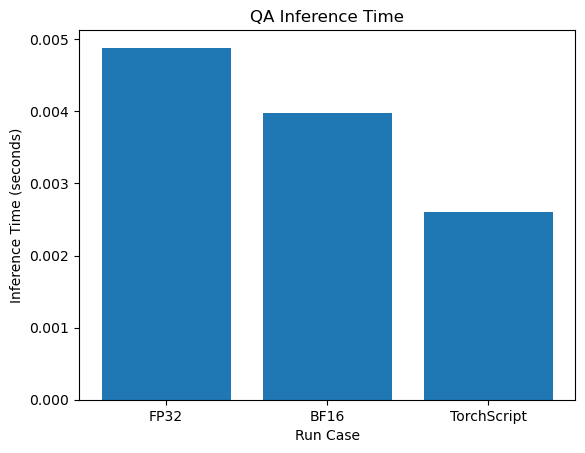

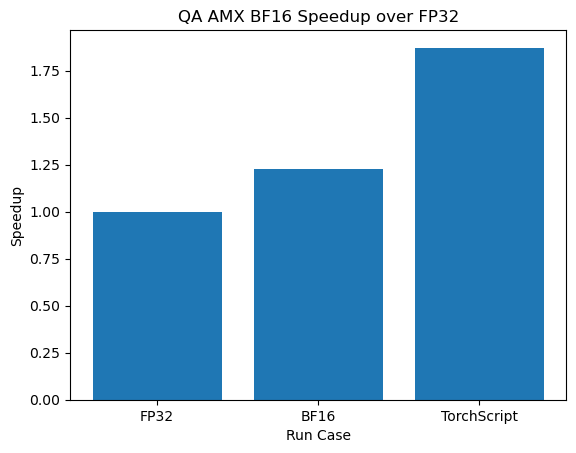

In [41]:
# Summarize and display results
#!pip install matplotlib
import matplotlib.pyplot as plt
results_bert = {
        "FP32": fp32_inference_time,
        "BF16": bf16_inference_time,
        "TorchScript": torchscript_inference_time
    }
summarize_results("QA", results_bert)
plt.show()